## Install Libraries & Master Functions

In [55]:
!pip install Quandl
!pip install investpy

In [56]:
!pip install missingno

In [117]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import quandl
import investpy

In [118]:
URL_array  = set()
def link2df(URL,col_name,join_df,join=True,check_column=True,check_URL = True,clear_URL_array=False,show_details=False):
    '''This function scraps the given link and returns dataframe
    __________
    Parameters:
        URL(string): URL to be scrapped from bitcoin website
        col_name(string): column name for dataframe
        join_df(variable)= dataframe withwhich output dataframe will be left joined on Date
        join(boolean)= iF True,join, else don't join
        check_column(boolean)= check if column name already exists
        check_URL(boolean)= check if URL is already processed
        clear_URL_array(boolean)= if true URL_processed array will be cleared
        show_details(boolean)= various details wil be printed such as scrapping first and last details, df head & df tail     
        '''
        
    print(f'processing {col_name}')

    #clear URL append array
    if clear_URL_array==True:
        URL_array.clear()

    #set join parameters if false
    if join == False:
        join_df = None
        check_column=False

    #process column name by making it lowercase and replacing spaces,commas, full stops
    col_name = col_name.lower().replace(',','').replace(" ", "_").replace(".", "_")

    #col_name validation if exists already
    if check_column==True and col_name in list(join_df.columns):
        print(f'column {col_name} already esists in dataframe, stopped here')
        return join_df

    #URL validation if processes already
    elif check_URL==True and URL in list(URL_array):
        print(f'{URL} is already processed, stopped here')
        return join_df 

    #web scrapping
    page = requests.get(URL)
    soup = page.content
    soup = str(soup)
    scraped_output = (soup.split('[[')[1]).split('{labels')[0][0:-2]
    if show_details == True:
        print('head')
        print({scraped_output[0:30]})
        print('tail')
        print({scraped_output[-30:]})

    processed_str = scraped_output.replace('new Date(','')
    processed_str = processed_str.replace(')','')
    processed_str = processed_str.replace('[','')
    processed_str = processed_str.replace(']','')
    processed_str = processed_str.replace('"','')

    processed_str_list = processed_str.split(',')
    date_list,data_list = processed_str_list[::2],processed_str_list[1::2]

    #validate column lengths
    if len(date_list)!=len(data_list):
        print(f'date & data length:{len(date_list),len(data_list),len(date_list)==len(data_list)}')

    #convert list data to a dataframe
    if join == False:
        df = pd.DataFrame()
        df['Date'] = pd.to_datetime(date_list)
        df[col_name] = data_list
        URL_array.add(URL)
        if show_details == True:
            print('*'*100)
            print('df head')
            print(df.head(1))
            print('*'*100)
            print('df tail')
            print(df.tail(1))
            print('*'*100)
            print(f'df shape{df.shape}')
            print('='*100)
            
        return df

    elif col_name not in list(join_df.columns) and join == True:
        df = pd.DataFrame()
        df['Date'] = pd.to_datetime(date_list)
        df[col_name] = data_list
        join_df = pd.merge(join_df,df,on=['Date'],how='left')
        URL_array.add(URL)
        if show_details == True:
            print('*'*100)
            print('df head')
            print(df.head(1))
            print('*'*100)
            print('df tail')
            print(df.tail(1))
            print('*'*100)
            print(f'output df shape= {df.shape},joined_df shape = {join_df.shape}')
            print('='*100)
            print(f'Number of duplicate columns in dataframe {df.columns.duplicated().sum()}')
            print('='*100)
    
        return join_df

## Web scraping

###01.Price

In [119]:
final_df = investpy.get_crypto_historical_data(crypto='bitcoin',from_date='01/01/2013',to_date='19/09/2021')

#final_df = investpy.get_crypto_historical_data(crypto='bitcoin',from_date='01/01/2013',to_date='19/09/2021')
final_df = final_df.reset_index()
final_df.drop(['Currency','Volume'],inplace=True,axis=1)
final_df.columns = ['Date','opening_price','highest_price','lowest_price','closing_price']
final_df

,Date,opening_price,highest_price,lowest_price,closing_price
0,2013-01-01,13.5,13.6,13.2,13.3
1,2013-01-02,13.3,13.4,13.2,13.3
2,2013-01-03,13.3,13.5,13.3,13.4
3,2013-01-04,13.4,13.5,13.3,13.5
4,2013-01-05,13.5,13.6,13.3,13.4
...,...,...,...,...,...
3179,2021-09-15,47070.8,48436.5,46743.9,48130.6
3180,2021-09-16,48132.3,48480.6,47040.3,47748.0
3181,2021-09-17,47748.2,48155.9,46788.8,47282.8
3182,2021-09-18,47283.9,48761.0,47070.5,48306.7


###02.Number of transactions in blockchain per day

In [120]:
final_df = link2df('https://bitinfocharts.com/comparison/bitcoin-transactions.html',
                   'transactions in blockchain',join_df=final_df,join=True)

processing transactions in blockchain


###03.Average block size

In [121]:
final_df = link2df('https://bitinfocharts.com/comparison/size-btc.html',
                   'avg block size',join_df=final_df,join=True)

processing avg block size


###04.Number of unique (from) addresses per day

In [122]:
final_df = link2df('https://bitinfocharts.com/comparison/sentbyaddress-btc.html',
                   'sent by adress',join_df=final_df,join=True)

processing sent by adress


###05.Average mining difficulty per day

In [123]:
final_df = link2df('https://bitinfocharts.com/comparison/bitcoin-difficulty.html',
                   'avg mining difficulty',join_df=final_df,join=True)

processing avg mining difficulty


###06.Average hashrate (hash/s) per day

In [124]:
final_df = link2df('https://bitinfocharts.com/comparison/bitcoin-hashrate.html',
                   'avg hashrate',join_df=final_df,join=True)

processing avg hashrate


###07.Mining Profitability USD/Day for 1 Hash/s

In [125]:
final_df = link2df('https://bitinfocharts.com/comparison/bitcoin-mining_profitability.html',
                   'mining profitability',join_df=final_df,join=True)

processing mining profitability


###08.Sent coins in USD per day

In [126]:
final_df = link2df('https://bitinfocharts.com/comparison/sentinusd-btc.html',
                   'Sent coins in USD',join_df=final_df,join=True)

processing Sent coins in USD


###09.Average transaction fee, USD

In [127]:
final_df = link2df('https://bitinfocharts.com/comparison/bitcoin-transactionfees.html',
                   'avg transaction fees',join_df=final_df,join=True)

processing avg transaction fees


###10.Median transaction fee, USD

In [128]:
final_df = link2df('https://bitinfocharts.com/comparison/bitcoin-median_transaction_fee.html',
                   'median transaction fees',join_df=final_df,join=True)

processing median transaction fees


###11.Average block time (minutes)

In [129]:
final_df = link2df('https://bitinfocharts.com/comparison/bitcoin-confirmationtime.html',
                   'avg block time',join_df=final_df,join=True)

processing avg block time


###12.Avg. Transaction Value, USD

In [130]:
final_df = link2df('https://bitinfocharts.com/comparison/transactionvalue-btc.html',
                   'avg transaction value',join_df=final_df,join=True)

processing avg transaction value


###13.Median Transaction Value, USD

In [131]:
final_df = link2df('https://bitinfocharts.com/comparison/mediantransactionvalue-btc.html',
                   'median transaction value',join_df=final_df,join=True)

processing median transaction value


###14.Tweets per day

In [132]:
final_df = link2df('https://bitinfocharts.com/comparison/tweets-btc.html',
                   'tweets',join_df=final_df,join=True)

processing tweets


###15.Google Trends to "Bitcoin" @ 2012-01-01

In [133]:
final_df = link2df('https://bitinfocharts.com/comparison/google_trends-btc.html',
                   'google trends',join_df=final_df,join=True)

processing google trends


###16.Number of unique (from or to) addresses per day

In [134]:
final_df = link2df('https://bitinfocharts.com/comparison/activeaddresses-btc.html',
                   'active addresses',join_df=final_df,join=True)

processing active addresses


###17.Top 100 Richest Addresses to Total coins %

In [135]:
final_df = link2df('https://bitinfocharts.com/comparison/top100cap-btc.html',
                   'top100 to total percentage',join_df=final_df,join=True)

processing top100 to total percentage


###18.Average Fee Percentage in Total Block Reward

In [136]:
final_df = link2df('https://bitinfocharts.com/comparison/fee_to_reward-btc.html',
                   'avg fee to reward',join_df=final_df,join=True)

processing avg fee to reward


###19.Total number of bitcoins in circulation

In [137]:
btc_in_circulation_df = quandl.get("BCHAIN/TOTBC",authtoken='9ztFCcK4_e1xGo_gjzK7')
btc_in_circulation_df = btc_in_circulation_df.rename(columns={'Value': 'number_of_coins_in_circulation'})

###20.Bitcoin Miners Revenue
Total value of coinbase block rewards and transaction fees paid to miners.

In [138]:
miners_revenue_df = quandl.get("BCHAIN/MIREV",authtoken='9ztFCcK4_e1xGo_gjzK7')
miners_revenue_df = miners_revenue_df.rename(columns={'Value': 'miner_revenue'})

###22.Additional Features

In [139]:
final_df

,Date,opening_price,highest_price,lowest_price,closing_price,transactions_in_blockchain,avg_block_size,sent_by_adress,avg_mining_difficulty,avg_hashrate,...,avg_transaction_fees,median_transaction_fees,avg_block_time,avg_transaction_value,median_transaction_value,tweets,google_trends,active_addresses,top100_to_total_percentage,avg_fee_to_reward
0,2013-01-01,13.5,13.6,13.2,13.3,31734,89033,26174,2979637,24331539528899,...,0.0107,0.0067,8.889,625.432,14.518,NaN,1.194,37846,19.536,0.627
1,2013-01-02,13.3,13.4,13.2,13.3,39280,114077,31809,2979637,22804647966378,...,0.0108,0.0066,9.412,650.617,14.514,NaN,1.497,43104,19.597,0.835
2,2013-01-03,13.3,13.5,13.3,13.4,42147,108023,38197,2979637,23724885599725,...,0.0118,0.00661,8.889,542.73,19.732,NaN,1.798,51268,19.621,0.925
3,2013-01-04,13.4,13.5,13.3,13.5,48436,141811,34990,2979637,22608181137438,...,0.0105,0.00661,9.412,632.431,11.384,NaN,1.841,47341,19.54,1
4,2013-01-05,13.5,13.6,13.3,13.4,39455,118240,38008,2979637,22590695489434,...,0.0105,0.00659,10.213,697.556,13.945,NaN,1.826,53417,19.543,0.885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3179,2021-09-15,47070.8,48436.5,46743.9,48130.6,268815,736726,500251,18415156832118,1.3302830209149E+20,...,3.018,0.863,10.141,702497,773.643,109407,89.096,823392,15.186,1.887
3180,2021-09-16,48132.3,48480.6,47040.3,47748.0,271087,817607,507192,18415156832118,1.302297111233E+20,...,2.966,0.808,10.588,766989,719.701,90855,86.404,879832,15.185,1.938
3181,2021-09-17,47748.2,48155.9,46788.8,47282.8,270893,720056,499224,18415156832118,1.272835239381E+20,...,2.631,0.712,9.796,612387,714.99,101046,81.131,823793,15.177,1.605
3182,2021-09-18,47283.9,48761.0,47070.5,48306.7,227506,563189,424384,18415156832118,1.4285050981775E+20,...,2.457,0.572,9.29,638205,593.076,82649,78.945,701986,15.185,1.183


In [140]:
#Filtering data as we are considering this peiod only
final_df = final_df[(final_df['Date'] >= '2013-01-01')].reset_index(drop=True)

In [141]:
final_df = pd.merge(final_df,btc_in_circulation_df,on=['Date'],how='left')
final_df = pd.merge(final_df,miners_revenue_df,on=['Date'],how='left')
final_df

,Date,opening_price,highest_price,lowest_price,closing_price,transactions_in_blockchain,avg_block_size,sent_by_adress,avg_mining_difficulty,avg_hashrate,...,avg_block_time,avg_transaction_value,median_transaction_value,tweets,google_trends,active_addresses,top100_to_total_percentage,avg_fee_to_reward,number_of_coins_in_circulation,miner_revenue
0,2013-01-01,13.5,13.6,13.2,13.3,31734,89033,26174,2979637,24331539528899,...,8.889,625.432,14.518,NaN,1.194,37846,19.536,0.627,10621175.00,5.264860e+04
1,2013-01-02,13.3,13.4,13.2,13.3,39280,114077,31809,2979637,22804647966378,...,9.412,650.617,14.514,NaN,1.497,43104,19.597,0.835,10621575.00,5.486525e+04
2,2013-01-03,13.3,13.5,13.3,13.4,42147,108023,38197,2979637,23724885599725,...,8.889,542.73,19.732,NaN,1.798,51268,19.621,0.925,10628700.00,4.811833e+04
3,2013-01-04,13.4,13.5,13.3,13.5,48436,141811,34990,2979637,22608181137438,...,9.412,632.431,11.384,NaN,1.841,47341,19.54,1,10632425.00,5.087274e+04
4,2013-01-05,13.5,13.6,13.3,13.4,39455,118240,38008,2979637,22590695489434,...,10.213,697.556,13.945,NaN,1.826,53417,19.543,0.885,10633200.00,5.139673e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3179,2021-09-15,47070.8,48436.5,46743.9,48130.6,268815,736726,500251,18415156832118,1.3302830209149E+20,...,10.141,702497,773.643,109407,89.096,823392,15.186,1.887,18816862.50,4.302687e+07
3180,2021-09-16,48132.3,48480.6,47040.3,47748.0,271087,817607,507192,18415156832118,1.302297111233E+20,...,10.588,766989,719.701,90855,86.404,879832,15.185,1.938,18817750.00,4.144786e+07
3181,2021-09-17,47748.2,48155.9,46788.8,47282.8,270893,720056,499224,18415156832118,1.272835239381E+20,...,9.796,612387,714.99,101046,81.131,823793,15.177,1.605,18818662.50,4.500074e+07
3182,2021-09-18,47283.9,48761.0,47070.5,48306.7,227506,563189,424384,18415156832118,1.4285050981775E+20,...,9.29,638205,593.076,82649,78.945,701986,15.185,1.183,18819693.75,4.781768e+07


In [82]:
final_df['next_day_closing_price'] = final_df['closing_price'].shift(-1)
final_df

,Date,opening_price,highest_price,lowest_price,closing_price,transactions_in_blockchain,avg_block_size,sent_by_adress,avg_mining_difficulty,avg_hashrate,...,avg_transaction_value,median_transaction_value,tweets,google_trends,active_addresses,top100_to_total_percentage,avg_fee_to_reward,number_of_coins_in_circulation,miner_revenue,next_day_closing_price
0,2013-01-01,13.5,13.6,13.2,13.3,31734,89033,26174,2979637,24331539528899,...,625.432,14.518,NaN,1.194,37846,19.536,0.627,10621175.00,5.264860e+04,13.3
1,2013-01-02,13.3,13.4,13.2,13.3,39280,114077,31809,2979637,22804647966378,...,650.617,14.514,NaN,1.497,43104,19.597,0.835,10621575.00,5.486525e+04,13.4
2,2013-01-03,13.3,13.5,13.3,13.4,42147,108023,38197,2979637,23724885599725,...,542.73,19.732,NaN,1.798,51268,19.621,0.925,10628700.00,4.811833e+04,13.5
3,2013-01-04,13.4,13.5,13.3,13.5,48436,141811,34990,2979637,22608181137438,...,632.431,11.384,NaN,1.841,47341,19.54,1,10632425.00,5.087274e+04,13.4
4,2013-01-05,13.5,13.6,13.3,13.4,39455,118240,38008,2979637,22590695489434,...,697.556,13.945,NaN,1.826,53417,19.543,0.885,10633200.00,5.139673e+04,13.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3179,2021-09-15,47070.8,48436.5,46743.9,48130.6,268815,736726,500251,18415156832118,1.3302830209149E+20,...,702497,773.643,109407,89.096,823392,15.186,1.887,18816862.50,4.302687e+07,47748.0
3180,2021-09-16,48132.3,48480.6,47040.3,47748.0,271087,817607,507192,18415156832118,1.302297111233E+20,...,766989,719.701,90855,86.404,879832,15.185,1.938,18817750.00,4.144786e+07,47282.8
3181,2021-09-17,47748.2,48155.9,46788.8,47282.8,270893,720056,499224,18415156832118,1.272835239381E+20,...,612387,714.99,101046,81.131,823793,15.177,1.605,18818662.50,4.500074e+07,48306.7
3182,2021-09-18,47283.9,48761.0,47070.5,48306.7,227506,563189,424384,18415156832118,1.4285050981775E+20,...,638205,593.076,82649,78.945,701986,15.185,1.183,18819693.75,4.781768e+07,47238.7


In [83]:
final_df.replace(to_replace='null', value=np.nan,inplace=True)
final_df.drop(final_df.tail(1).index,inplace=True)
final_df

,Date,opening_price,highest_price,lowest_price,closing_price,transactions_in_blockchain,avg_block_size,sent_by_adress,avg_mining_difficulty,avg_hashrate,...,avg_transaction_value,median_transaction_value,tweets,google_trends,active_addresses,top100_to_total_percentage,avg_fee_to_reward,number_of_coins_in_circulation,miner_revenue,next_day_closing_price
0,2013-01-01,13.5,13.6,13.2,13.3,31734,89033,26174,2979637,24331539528899,...,625.432,14.518,NaN,1.194,37846,19.536,0.627,10621175.00,5.264860e+04,13.3
1,2013-01-02,13.3,13.4,13.2,13.3,39280,114077,31809,2979637,22804647966378,...,650.617,14.514,NaN,1.497,43104,19.597,0.835,10621575.00,5.486525e+04,13.4
2,2013-01-03,13.3,13.5,13.3,13.4,42147,108023,38197,2979637,23724885599725,...,542.73,19.732,NaN,1.798,51268,19.621,0.925,10628700.00,4.811833e+04,13.5
3,2013-01-04,13.4,13.5,13.3,13.5,48436,141811,34990,2979637,22608181137438,...,632.431,11.384,NaN,1.841,47341,19.54,1,10632425.00,5.087274e+04,13.4
4,2013-01-05,13.5,13.6,13.3,13.4,39455,118240,38008,2979637,22590695489434,...,697.556,13.945,NaN,1.826,53417,19.543,0.885,10633200.00,5.139673e+04,13.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3178,2021-09-14,44950.2,47247.6,44718.7,47077.5,267959,599399,491643,18415156832118,1.5551719497901E+20,...,1932378,717.117,91267,90.85,793939,15.218,1.394,18816150.00,4.946986e+07,48130.6
3179,2021-09-15,47070.8,48436.5,46743.9,48130.6,268815,736726,500251,18415156832118,1.3302830209149E+20,...,702497,773.643,109407,89.096,823392,15.186,1.887,18816862.50,4.302687e+07,47748.0
3180,2021-09-16,48132.3,48480.6,47040.3,47748.0,271087,817607,507192,18415156832118,1.302297111233E+20,...,766989,719.701,90855,86.404,879832,15.185,1.938,18817750.00,4.144786e+07,47282.8
3181,2021-09-17,47748.2,48155.9,46788.8,47282.8,270893,720056,499224,18415156832118,1.272835239381E+20,...,612387,714.99,101046,81.131,823793,15.177,1.605,18818662.50,4.500074e+07,48306.7


## Missing Value Imputation

In [84]:
missing_values = pd.DataFrame(final_df.isna().sum(),columns=['missing_count'])
missing_values.sort_values(by='missing_count',ascending=False)

,missing_count
tweets,519
active_addresses,22
top100_to_total_percentage,6
avg_block_time,1
Date,0
median_transaction_fees,0
miner_revenue,0
number_of_coins_in_circulation,0
avg_fee_to_reward,0
google_trends,0


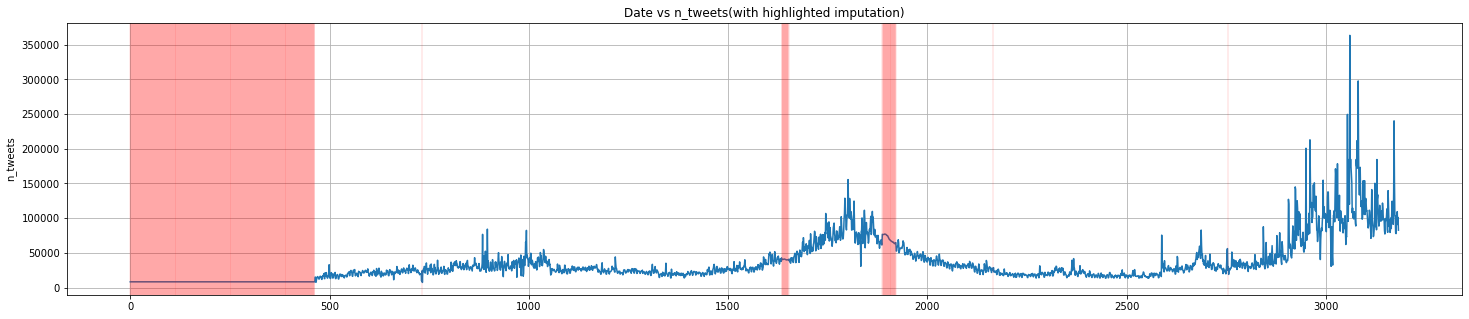

In [85]:
final_df['tweets'].fillna(final_df['tweets'].rolling(40, min_periods=1).mean()).bfill().astype(float).plot(x=final_df['Date'],y='tweets',figsize=(25,5),grid=True)
for i in list(final_df.loc[pd.isna(final_df['tweets']), :].index):
    plt.axvline(x=i,color='r',alpha=0.1)
plt.ylabel('n_tweets')
plt.title('Date vs n_tweets(with highlighted imputation)')
plt.show()
final_df['tweets'] = final_df['tweets'].fillna(final_df['tweets'].rolling(40, min_periods=1).mean()).bfill()

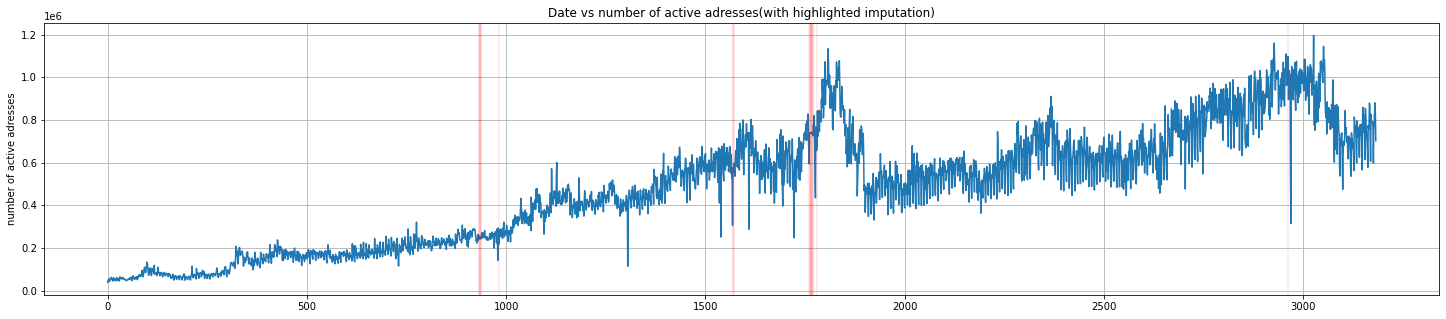

In [86]:
final_df['active_addresses'].fillna(final_df['active_addresses'].rolling(14, min_periods=1).mean()).astype(float).plot(x=final_df['Date'],y='active_addresses',figsize=(25,5),grid=True)
for i in list(final_df.loc[pd.isna(final_df['active_addresses']),:].index):
    plt.axvline(x=i,color='r',alpha=0.1)
plt.ylabel('number of active adresses')
plt.title('Date vs number of active adresses(with highlighted imputation)')
plt.show()
final_df['active_addresses'] = final_df['active_addresses'].fillna(final_df['active_addresses'].rolling(14, min_periods=1).mean())

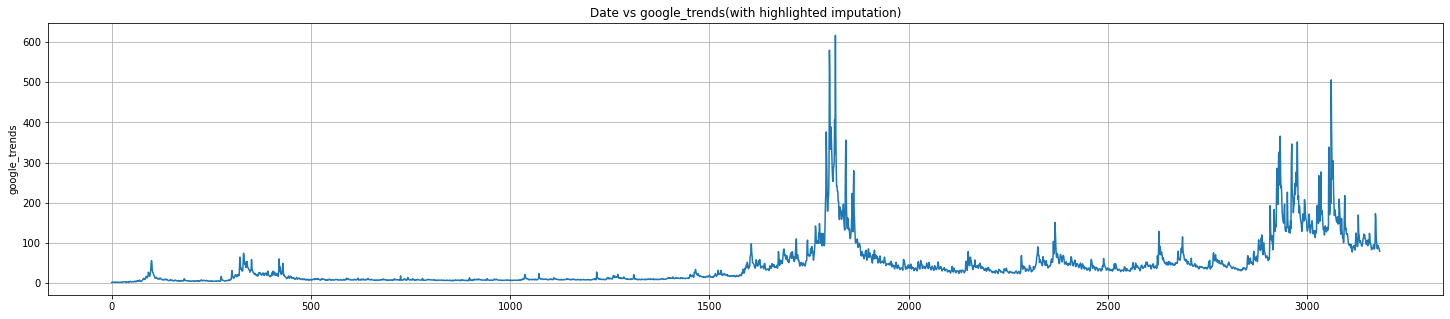

In [87]:
final_df['google_trends'].fillna(final_df['google_trends'].rolling(14, min_periods=1).mean()).astype(float).plot(x=final_df['Date'],y='google_trends',figsize=(25,5),grid=True)
for i in list(final_df.loc[pd.isna(final_df['google_trends']), :].index):
    plt.axvline(x=i,color='r',alpha=0.1)
plt.ylabel('google_trends')
plt.title('Date vs google_trends(with highlighted imputation)')
plt.show()
final_df['google_trends'] = final_df['google_trends'].fillna(final_df['google_trends'].rolling(14, min_periods=1).mean())

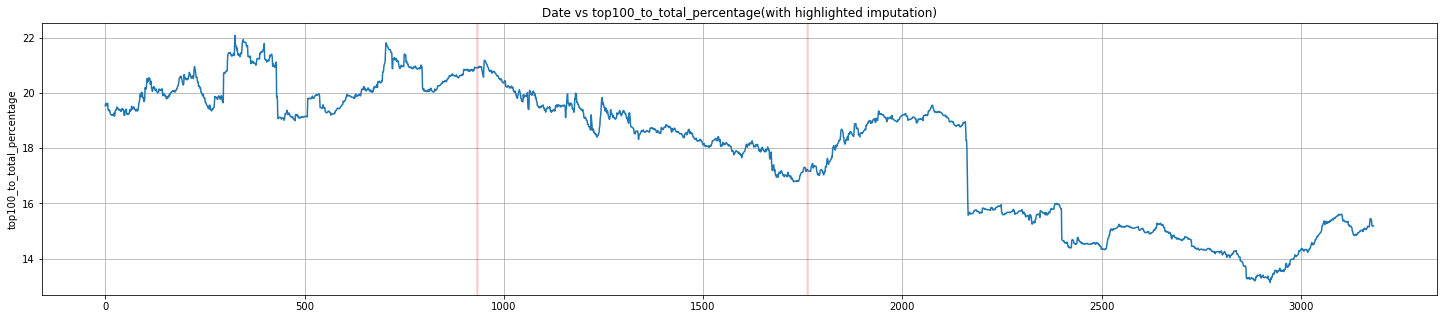

In [88]:
final_df['top100_to_total_percentage'].fillna(final_df['top100_to_total_percentage'].rolling(7, min_periods=1).mean()).astype(float).plot(x=final_df['Date'],y='top100_to_total_percentage',figsize=(25,5),grid=True)
for i in list(final_df.loc[pd.isna(final_df['top100_to_total_percentage']), :].index):
    plt.axvline(x=i,color='r',alpha=0.1)
plt.ylabel('top100_to_total_percentage')
plt.title('Date vs top100_to_total_percentage(with highlighted imputation)')
plt.show()
final_df['top100_to_total_percentage'] = final_df['top100_to_total_percentage'].fillna(final_df['top100_to_total_percentage'].rolling(7, min_periods=1).mean())

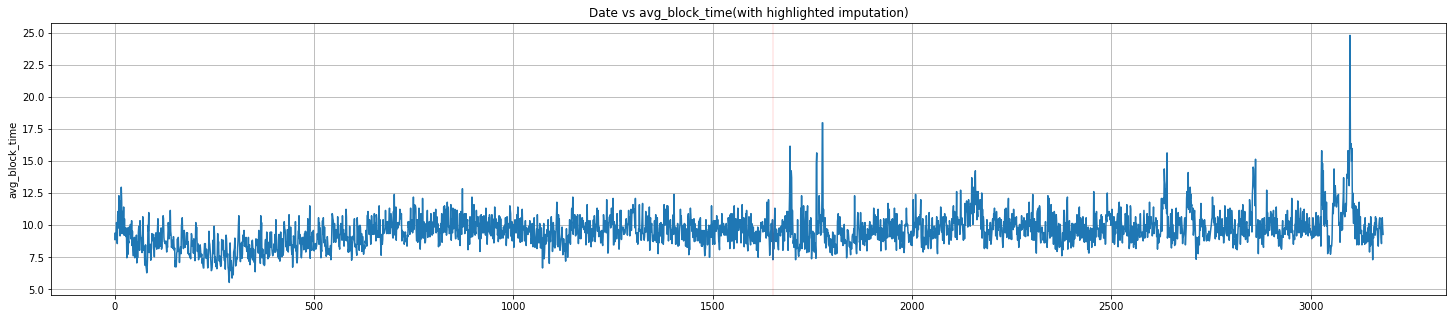

In [89]:
final_df['avg_block_time'].fillna(final_df['avg_block_time'].rolling(7, min_periods=1).mean()).astype(float).plot(x=final_df['Date'],y='avg_block_time',figsize=(25,5),grid=True)
for i in list(final_df.loc[pd.isna(final_df['avg_block_time']), :].index):
    plt.axvline(x=i,color='r',alpha=0.1)
plt.ylabel('avg_block_time')
plt.title('Date vs avg_block_time(with highlighted imputation)')
plt.show()
final_df['avg_block_time'] = final_df['avg_block_time'].fillna(final_df['avg_block_time'].rolling(7, min_periods=1).mean())

In [90]:
missing_values = pd.DataFrame(final_df.isna().sum(),columns=['missing_count'])
missing_values.sort_values(by='missing_count',ascending=False)

,missing_count
Date,0
median_transaction_fees,0
miner_revenue,0
number_of_coins_in_circulation,0
avg_fee_to_reward,0
top100_to_total_percentage,0
active_addresses,0
google_trends,0
tweets,0
median_transaction_value,0


In [91]:
final_df.to_csv('final_data_imputed_20210919.csv',index=False)

In [93]:
final_df.head()

,Date,opening_price,highest_price,lowest_price,closing_price,transactions_in_blockchain,avg_block_size,sent_by_adress,avg_mining_difficulty,avg_hashrate,...,avg_transaction_value,median_transaction_value,tweets,google_trends,active_addresses,top100_to_total_percentage,avg_fee_to_reward,number_of_coins_in_circulation,miner_revenue,next_day_closing_price
0,2013-01-01,13.5,13.6,13.2,13.3,31734,89033,26174,2979637,24331539528899,...,625.432,14.518,8193,1.194,37846,19.536,0.627,10621175.0,52648.600000,13.3
1,2013-01-02,13.3,13.4,13.2,13.3,39280,114077,31809,2979637,22804647966378,...,650.617,14.514,8193,1.497,43104,19.597,0.835,10621575.0,54865.251543,13.4
2,2013-01-03,13.3,13.5,13.3,13.4,42147,108023,38197,2979637,23724885599725,...,542.73,19.732,8193,1.798,51268,19.621,0.925,10628700.0,48118.330620,13.5
3,2013-01-04,13.4,13.5,13.3,13.5,48436,141811,34990,2979637,22608181137438,...,632.431,11.384,8193,1.841,47341,19.54,1,10632425.0,50872.740000,13.4
4,2013-01-05,13.5,13.6,13.3,13.4,39455,118240,38008,2979637,22590695489434,...,697.556,13.945,8193,1.826,53417,19.543,0.885,10633200.0,51396.725494,13.4


In [142]:
final_df.tail()

,Date,opening_price,highest_price,lowest_price,closing_price,transactions_in_blockchain,avg_block_size,sent_by_adress,avg_mining_difficulty,avg_hashrate,...,avg_block_time,avg_transaction_value,median_transaction_value,tweets,google_trends,active_addresses,top100_to_total_percentage,avg_fee_to_reward,number_of_coins_in_circulation,miner_revenue
3179,2021-09-15,47070.8,48436.5,46743.9,48130.6,268815,736726,500251,18415156832118,1.3302830209149E+20,...,10.141,702497,773.643,109407,89.096,823392,15.186,1.887,18816862.50,4.302687e+07
3180,2021-09-16,48132.3,48480.6,47040.3,47748.0,271087,817607,507192,18415156832118,1.302297111233E+20,...,10.588,766989,719.701,90855,86.404,879832,15.185,1.938,18817750.00,4.144786e+07
3181,2021-09-17,47748.2,48155.9,46788.8,47282.8,270893,720056,499224,18415156832118,1.272835239381E+20,...,9.796,612387,714.99,101046,81.131,823793,15.177,1.605,18818662.50,4.500074e+07
3182,2021-09-18,47283.9,48761.0,47070.5,48306.7,227506,563189,424384,18415156832118,1.4285050981775E+20,...,9.29,638205,593.076,82649,78.945,701986,15.185,1.183,18819693.75,4.781768e+07
3183,2021-09-19,48299.9,48341.9,46866.6,47238.7,200356,462254,371685,18415156832118,1.4849890652169E+20,...,9,597599,549.251,74123,76.559,612716,15.194,0.819,18820581.25,4.813199e+07
